In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns

In [2]:
df = pd.read_pickle('sample_stats.pkl')

In [3]:
liquid = np.array([0.363497, 0.370059])
spread = np.array([0.567081, 0.468995])

def simulate_additional_replicates(a, b, test, n_replicates, n_iterations):
    mean_a = np.mean(a)
    mean_b = np.mean(b)
    stdev_a = np.std(a)
    stdev_b= np.std(b)

    p_values = {}

    for i in range(n_replicates):
        a_samples = np.random.normal(loc=mean_a, scale=stdev_a, size=[i + 2, n_iterations])
        b_samples = np.random.normal(loc=mean_b, scale=stdev_b, size=[i + 2, n_iterations])
        p_values[i + 2] = test(a_samples, b_samples).pvalue

    return p_values




In [4]:
sample_names = names_dict = ['semisolid', 'high density spread', 'bead spread', 'low density spread']
liquid_gini = df[(df['variable'] == 'gini') & (df['sample'] == 'liquid')]['value']
p_values = {}
for sample in sample_names:
    sample_gini = df[(df['variable'] == 'gini') & (df['sample'] == sample)]['value']
    p_values[sample] = pd.DataFrame.from_dict(simulate_additional_replicates(liquid_gini, sample_gini, stats.ttest_rel, 9, 1000))

In [5]:
df_sim = pd.concat([p_values[i] for i in sample_names], keys=sample_names).reset_index()
df_sim = df_sim.rename(columns={'level_0': 'sample'})
df_sim = df_sim.drop('level_1', axis=1)
df_sim
df_sim_long = df_sim.melt(id_vars=['sample'], var_name='replicates', value_name='p_value')
# df_sim_long
df_sim_long


,sample,replicates,p_value
0,semisolid,2,0.144984
1,semisolid,2,0.528534
2,semisolid,2,0.572324
3,semisolid,2,0.353644
4,semisolid,2,0.180717
...,...,...,...
35995,low density spread,10,0.001343
35996,low density spread,10,0.000025
35997,low density spread,10,0.000023
35998,low density spread,10,0.000009


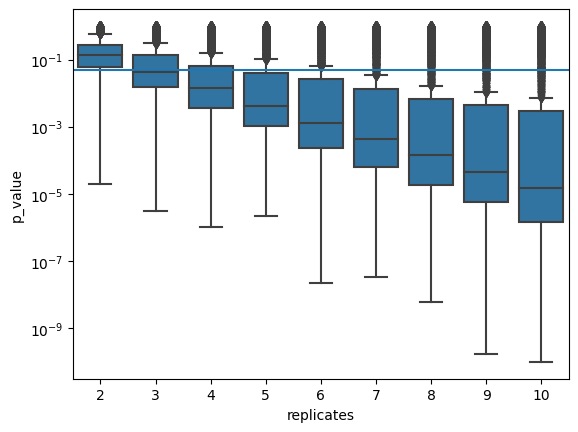

In [6]:
g = sns.boxplot(df_sim_long, x='replicates', y='p_value', color=sns.color_palette()[0])
g.axhline(0.05)
plt.yscale('log')

c:\Users\nmateyko\.venv\plab\lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


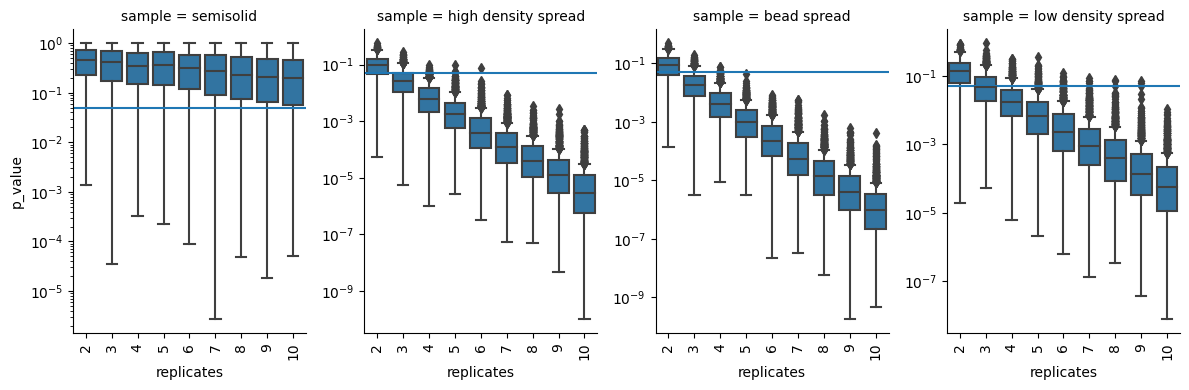

In [7]:
g = sns.FacetGrid(df_sim_long, col='sample',
                  col_order=sample_names,
                  col_wrap=4, height=4, aspect=0.75, sharex=False, sharey=False)
g.map(sns.boxplot, 'replicates', 'p_value', color=sns.color_palette()[0]).set(yscale = 'log')
for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
for axis in g.axes:
    axis.axhline(0.05)
plt.tight_layout()
# plt.savefig("images/stats.svg")
# g.axhline(0.05)
plt.show()

In [8]:
df_sim_long['<0.05'] = df_sim_long['p_value'] < 0.05
df_sim_long

,sample,replicates,p_value,<0.05
0,semisolid,2,0.144984,False
1,semisolid,2,0.528534,False
2,semisolid,2,0.572324,False
3,semisolid,2,0.353644,False
4,semisolid,2,0.180717,False
...,...,...,...,...
35995,low density spread,10,0.001343,True
35996,low density spread,10,0.000025,True
35997,low density spread,10,0.000023,True
35998,low density spread,10,0.000009,True


In [9]:
percent_sig = df_sim_long.drop('p_value', axis=1).groupby(['sample', 'replicates']).value_counts(normalize=True)
